# about this notebook
두 가지 변경사항을 python script들에 반영하기 전에 시험해본다. 변경 사항은 다음과 같다.  
- img를 읽어올 때, json도 같이 읽어서 라벨 폴리곤을 그려넣는다. (파란색이 어떨까)
- img_generation_utils 의 batch generator도 바꿔서 파일 경로도 return 하도록 한다.

In [110]:

import argparse
import json
import os
from matplotlib import pyplot as plt
import sys

import tensorflow as tf

from rz_cvae.utils import batch_generator, convert_batch_to_image_grid, read_data

# Read test_data.pickle 
test_data = read_data("./test_data")

#path = l/rz_cvae/image_data

In [111]:
len(test_data['img_paths'])

383

# 이미지 생성시 원본 경로도 출력하기
원래 이런 코드로 실행된다. 이걸 하면 이미지만 출력하는 것이 아니라 file paths도 출력되게 만들자. 그리고 지정 이미지에서 만들 수 있게 해도 좋겠는데  
```python
test_data = read_data("./test_data")
image_reconstruction(model, test_data, save_path=None) 
```

## rz_cvae/utils.py 의 함수

In [4]:
def create_image_batch(labels, model_name, use_train=False, path_return=False):
    """
    Returns the list of images corresponding to the given labels.
    """
    imgs = []
    paths = []
    imgs_id = [item[0] for item in labels]
    
    #hard code few lines...
    test_data = read_data("./test_data")
    img_paths = test_data['img_paths'][-len(test_data['test_img_ids']):] # split of test_data paths
    #img_paths = test_data['img_paths'][:-len(test_data['test_img_ids'])] # split of train_data paths
    path_cols=[0,1]

    for i in imgs_id:
        img = []
        for j in range(len(path_cols)):
            image_path = img_paths[i][j]
            paths.append(image_path)
            img.append(get_image(image_path, model_name))
        imgs.append(np.concatenate(tuple(img),axis=-1))
    if path_return=True:
        return imgs, paths
    else:
        return imgs

def get_image(image_path, model_name, img_resize = 1024):
    """
    Crops, resizes and normalizes the target image.
        - If model_name == Dense, the image is returned as a flattened numpy array with dim (64*64*3)
        - otherwise, the image is returned as a numpy array with dim (64,64,3)
    """

    img = cv2.imread(image_path)
    img = cv2.resize(img, (img_resize, img_resize))
    img = np.array(img, dtype='float32')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img /= 255.0 # Normalization to [0.,1.]

    if model_name == "Dense" :
        img = img.ravel()
    
    return img

def batch_generator(batch_dim, test_labels, model_name):
    """
    Batch generator using the given list of labels.
    """
    while True:
        batch_imgs = []
        labels = []
        for label in (test_labels):
            labels.append(label)
            if len(labels) == batch_dim:
                batch_imgs, img_paths = create_image_batch(labels, model_name, path_return=True)
                batch_labels = [x[1] for x in labels]
                yield np.asarray(batch_imgs), np.asarray(batch_labels), img_paths
                batch_imgs = []
                labels = []
                batch_labels = []
        if batch_imgs:
            yield np.asarray(batch_imgs), np.asarray(batch_labels), img_paths

## img reconstruction 함수
rz_cvae/image_generation_utils.py

In [ ]:
def image_reconstruction(model, test_data, save_path=None):
    """
    Reconstructs and plots a bacth of test images.
    """

    batch_gen, paths = batch_generator(test_data['batch_size'], test_data['test_img_ids'], model_name = 'Conv')
    images, labels= next(batch_gen)
    model_output= model((images, labels), is_train = False)
    
    print(paths)
    
    f = plt.figure(figsize=(24,60))
    ax = f.add_subplot(1,2,1)
    ax.imshow(convert_batch_to_image_grid(images))
    plt.axis('off')

    ax = f.add_subplot(1,2,2)
    ax.imshow(convert_batch_to_image_grid(model_output['recon_img'].numpy()))
    plt.axis('off')
    
    if save_path :
        plt.savefig(save_path + "reconstruction.png")

    plt.show()
    plt.clf()

    print("Reconstruction of a batch of test set images.")


In [113]:
batch_gen = batch_generator(test_data['batch_size'], test_data['test_img_ids'], model_name = 'Conv')

In [114]:
len(test_data['img_paths'])

383

In [115]:
len(test_data['test_img_ids'])

20

In [119]:
td=test_data['img_paths'][-len(test_data['test_img_ids']):]
td

array([['sample_img/imgCrop_RI/20200928_13_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200928_13_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200928_14_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200928_14_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200928_15_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200928_15_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200928_16_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200928_16_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200929_09_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200929_09_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200929_10_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200929_10_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200929_11_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200929_11_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200929_12_RI.JPG.jpg',
        'sample_img/imgCrop_CHL/20200929_12_CHL.JPG.jpg'],
       ['sample_img/imgCrop_RI/20200929_13_RI.JPG.jpg',
        'sample_img/imgC

In [121]:
[x[0].split('/')[-1] for x in td] # x[0] for RI files, x[1] for CHL files

['20200928_13_RI.JPG.jpg',
 '20200928_14_RI.JPG.jpg',
 '20200928_15_RI.JPG.jpg',
 '20200928_16_RI.JPG.jpg',
 '20200929_09_RI.JPG.jpg',
 '20200929_10_RI.JPG.jpg',
 '20200929_11_RI.JPG.jpg',
 '20200929_12_RI.JPG.jpg',
 '20200929_13_RI.JPG.jpg',
 '20200929_14_RI.JPG.jpg',
 '20200929_15_RI.JPG.jpg',
 '20200929_16_RI.JPG.jpg',
 '20200930_09_RI.JPG.jpg',
 '20200930_10_RI.JPG.jpg',
 '20200930_11_RI.JPG.jpg',
 '20200930_12_RI.JPG.jpg',
 '20200930_13_RI.JPG.jpg',
 '20200930_14_RI.JPG.jpg',
 '20200930_15_RI.JPG.jpg',
 '20200930_16_RI.JPG.jpg']

# 이미지에 라벨 폴리곤 넣기

In [95]:
import os
path = 'image_data/RI'
data_files = os.listdir(path)

print(len([x for x in data_files if x.split('.')[-1]=='jpg']))

390


In [96]:
jsons = [x for x in data_files if x.split('.')[-1]=='json']
print(len(jsons),len(data_files))

269 659


In [97]:
import json
fp = open(os.path.join(path, jsons[0]), "r")
a=json.load(fp)

In [98]:
points = a['shapes'][0]['points']
points

[[2.127659574468085, 724.4574468085106],
 [0.0, 665.9468085106382],
 [19.148936170212764, 654.7765957446808],
 [42.5531914893617, 659.031914893617],
 [49.46808510638298, 674.9893617021277],
 [53.191489361702125, 689.8829787234042],
 [69.14893617021276, 705.8404255319149],
 [82.97872340425532, 706.9042553191489],
 [101.06382978723404, 689.3510638297872],
 [104.78723404255318, 677.1170212765957],
 [126.06382978723404, 679.2446808510638],
 [131.38297872340425, 690.9468085106382],
 [120.2127659574468, 698.9255319148936],
 [105.31914893617021, 713.8191489361702],
 [120.2127659574468, 720.7340425531914],
 [135.63829787234042, 714.8829787234042],
 [157.9787234042553, 726.5851063829787],
 [153.72340425531914, 746.2659574468084],
 [97.8723404255319, 746.7978723404254],
 [77.6595744680851, 755.8404255319149],
 [46.80851063829787, 748.3936170212766],
 [9.042553191489361, 767.0106382978723],
 [0.0, 765.4148936170212]]

In [99]:
a['imageWidth'], type(a['imageWidth'])

(1216, int)

In [100]:
a['imageHeight']

1192

In [101]:
import numpy as np
import cv2 as cv

In [102]:
blue_color = (0,0,255)

img = np.zeros((a['imageHeight'], a['imageWidth'], 3), np.uint8)
pts = np.array(points, np.int32)
pts = pts.reshape((-1, 1, 2))
img = cv.polylines(img, [pts], True, blue_color, 3)

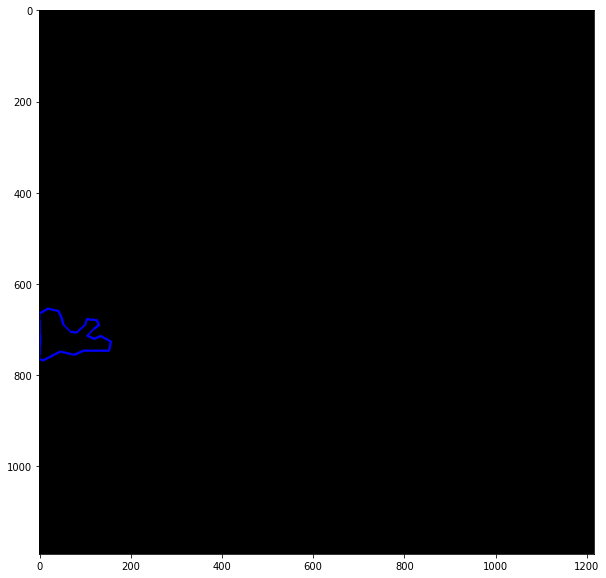

In [103]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(img)

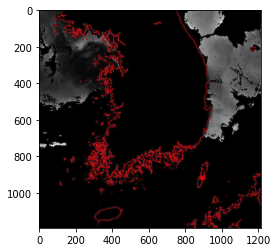

In [105]:
orig_img = plt.imread(os.path.join(path, a['imagePath']))
plt.imshow(orig_img)

In [106]:
orig_img.shape

(1192, 1216, 3)

In [107]:
img.shape

(1192, 1216, 3)

# 이미지 병합: 두 가지 방법
cv2.add 를 쓰는 것이 낫겠다.

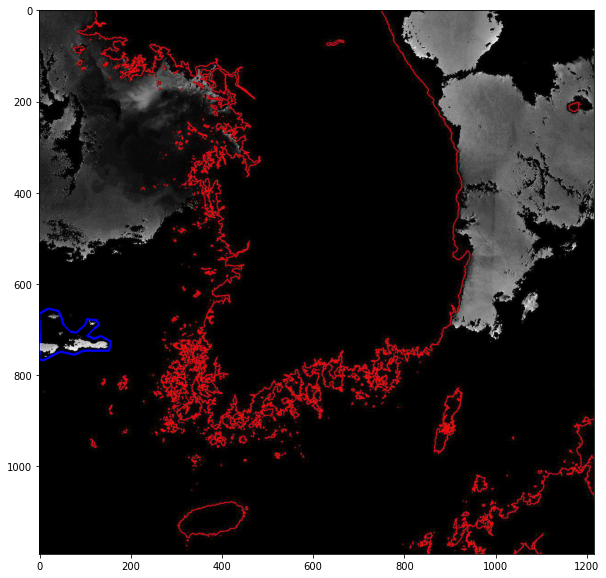

In [108]:
merged_img = cv.add(orig_img, img)
plt.figure(figsize=(10,10))
plt.imshow(merged_img)

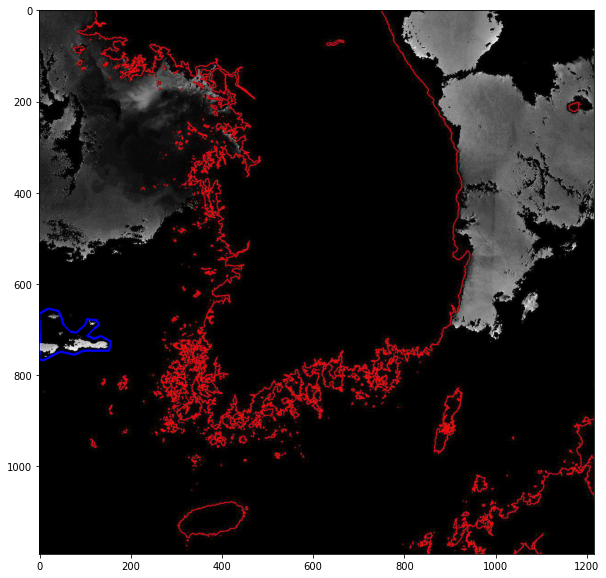

In [94]:
for i in range(len(orig_img)):
    for j in range(len(orig_img[0])):
        orig_img[i, j, 2] = min(np.int32(orig_img[i, j, 2])+img[i, j, 2], 255)
plt.figure(figsize=(10,10))
plt.imshow(orig_img)

## 데이터는 어떻게 저장할까?
크게 두 가지 방법을 생각할 수 있겠다.  
1. 병합된 이미지 따로 저장해두기 : 저장공간을 낭비하는 셈인데 그렇게 부담이 되진 않는다.  
2. 라벨 폴리곤 이미지만 따로 저장해두기 : 저장공간을 조금 낭비하는 셈인데 그렇게 부담이 되진 않는다.  
3. json을 가지고 이미지 불러올 때 합치기 : 저장공간이 아껴지는데 이걸 하면 batch를 구성할 때마다 위 과정을 되풀이해야 한다.  

## list_attr.csv 의 수정 방법
list_attr.csv 파일은 센서 데이터와 일시별 파일 경로를 포함하고 있다. RI_file 말고 column을 하나 더 추가해서 label에 관련된 파일을 넣자. 이미지이든 json 파일이든.  
list_attr.csv 파일은 [이 노트북](https://github.com/chhyyi/aiffelthon/blob/main/cvae_poc/cvae_poc.ipynb)으로 만들었다. 여기다 복붙하겠다. 다만 ri, chl에 더해 json 파일에 대한 처리도 같이 한다.

In [122]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
path_RI = 'image_data/RI'
path_CHL = 'image_data/CHL'

sample_chls=os.listdir(path_CHL)
sample_chls=[os.path.join(path_CHL, i) for i in sample_chls]
sample_ris=os.listdir(path_RI)
sample_ris=[os.path.join(path_RI, i) for i in sample_ris if i.split('.')[-1]=='jpg']
jsons=[os.path.join(path_RI, i) for i in sample_ris if i.split('.')[-1]=='json']

#print(sample_chls)
print(len(sample_chls), len(sample_ris))


386 390


In [123]:
import pandas as pd
sample_chls_fn_split=[list(i.split('.')[0].split('_'))+[i] for i in sample_chls]
sample_ris_fn_split=[list(i.split('.')[0].split('_'))+[i] for i in sample_ris]
jsons_fn_split=[list(i.split('.')[0].split('_'))+[i] for i in jsons]

sample_chls_df=pd.DataFrame(sample_chls_fn_split, columns=['date', 'hour', 'product','file'])
sample_ris_df=pd.DataFrame(sample_ris_fn_split, columns=['date', 'hour', 'product','file'])
jsons_df=pd.DataFrame(jsons_fn_split, columns=['date', 'hour', 'product','file'])

sample_ris_df.dropna(inplace=True)
sample_ris_df['file']=sample_ris_df['file'].apply(lambda x:os.path.join(path_RI,x))
sample_chls_df.dropna(inplace=True)
sample_chls_df['file']=sample_chls_df['file'].apply(lambda x:os.path.join(path_CHL,x))
jsons_df.dropna(inplace=True)
jsons_df['file']=jsons_df['file'].apply(lambda x:os.path.join(path_RI,x))

sample_chls_df.sort_values(by=['date', 'hour'], inplace=True)
sample_ris_df.sort_values(by=['date', 'hour'], inplace=True)
jsons_df.sort_values(by=['date', 'hour'], inplace=True)

sample_ris_df['year']=sample_ris_df['date'].astype('datetime64[D]').apply(lambda x:x.year)
sample_ris_df['mm']=sample_ris_df['date'].astype('datetime64[D]').apply(lambda x:x.month)
sample_ris_df['dd']=sample_ris_df['date'].astype('datetime64[D]').apply(lambda x:x.day)
sample_ris_df['hh']=sample_ris_df['hour'].astype('int')
sample_ris_df.drop(columns=['date', 'hour'], inplace=True)
sample_ris_df.reset_index(drop=True, inplace=True)

sample_chls_df['year']=sample_chls_df['date'].astype('datetime64[D]').apply(lambda x:x.year)
sample_chls_df['mm']=sample_chls_df['date'].astype('datetime64[D]').apply(lambda x:x.month)
sample_chls_df['dd']=sample_chls_df['date'].astype('datetime64[D]').apply(lambda x:x.day)
sample_chls_df['hh']=sample_chls_df['hour'].astype('int')
sample_chls_df.drop(columns=['date', 'hour'], inplace=True)
sample_chls_df.reset_index(drop=True, inplace=True)


jsons_df['year']=jsons_df['date'].astype('datetime64[D]').apply(lambda x:x.year)
jsons_df['mm']=jsons_df['date'].astype('datetime64[D]').apply(lambda x:x.month)
jsons_df['dd']=jsons_df['date'].astype('datetime64[D]').apply(lambda x:x.day)
jsons_df['hh']=jsons_df['hour'].astype('int')
jsons_df.drop(columns=['date', 'hour'], inplace=True)
jsons_df.reset_index(drop=True, inplace=True)

sensory=os.path.join(os.getenv('HOME'), 'aiffel/aiffelthon/sample_data/observe_train_refined_with_datetime.csv')
sensory=pd.read_csv(sensory, index_col = 0)
sensory.drop(columns='interpolated', inplace=True)

ValueError: 4 columns passed, passed data had 5 columns

In [ ]:
sensory.iloc[:,:-5]=(sensory.iloc[:,:-5]-sensory.iloc[:,:-5].min())/(sensory.iloc[:,:-5].max()-sensory.iloc[:,:-5].min()) #distributed 0~1
sensory